In [1]:
import numpy as np
import xarray as xr
from modules.ADI import ADI
from modules.classes import Quantity2D, Analytic
import matplotlib.pyplot as plt

In [2]:
# Initialize a constant diffusion coefficient function
diffusion = Analytic(lambda x, y: 1)
diffusion.set_partial_x(lambda x, y: 0)
diffusion.set_partial_y(lambda x, y: 0)

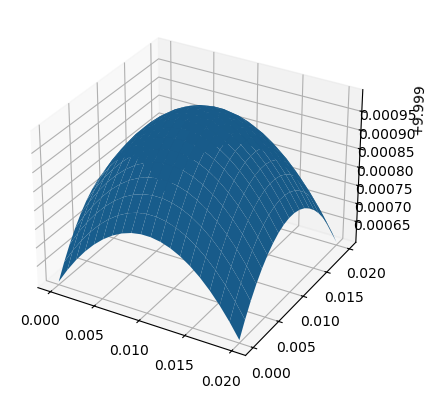

In [3]:
n_grid = 20
n_time = 50
dt = 0.0001
dx = 0.001
dy = 0.001
conc = Quantity2D(
    n_grid,
    n_time,
    (0, n_grid*dx),
    (0, n_grid*dy),
    (0, dt*n_time),
)

xcoords = conc.xcoords
ycoords = conc.ycoords
X, Y = np.meshgrid(xcoords, ycoords)
initial_condition =  10*np.exp(- (10*n_grid*dx)*((X - 0.5*dx*n_grid)**2 + (Y - 0.5*dy*n_grid)**2))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, initial_condition)

In [4]:
result_ds = ADI(conc, diffusion, initial_condition)

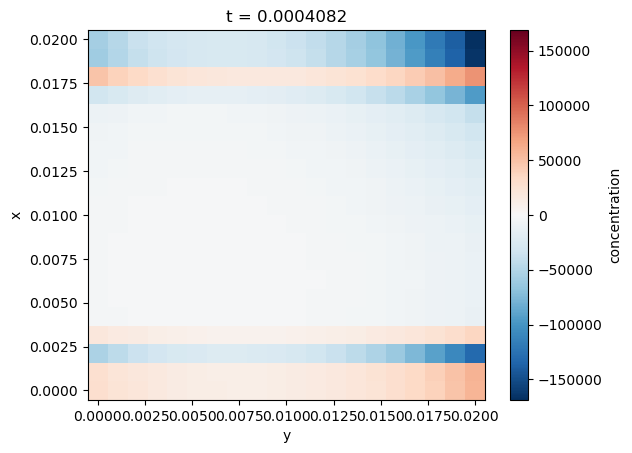

In [5]:
result_ds.isel(t=4).plot()